In [1]:
#data tools
from src import prepare_europe_data, prepare_empty_frame, plot_covid_data, get_daily_cases, tukey_outliers, crosscorr
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import itertools

#linear algebra/ math
import numpy as np
from math import sqrt
np.random.seed(420)

#plots
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot
plt.style.use('seaborn')

#metrics
from sklearn.metrics import mean_squared_error

#statistical tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats

#models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import curve_fit
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data_path = '../../data/raw/time_series_covid19_confirmed_global.csv'
data_raw = pd.read_csv(data_path)
data_prepared_poland = prepare_europe_data(data=data_raw, start_date='4/1/20', end_date='5/13/20', country='Poland')
df = data_prepared_poland

In [3]:
plot_covid_data(data=data_prepared_poland, country='Poland')

In [4]:
df, daily_growth_series = get_daily_cases(df)

In [5]:
df = data_prepared_poland
df = df.T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.rename({'Poland': 'PolandConfirmedCases'}, axis=1)

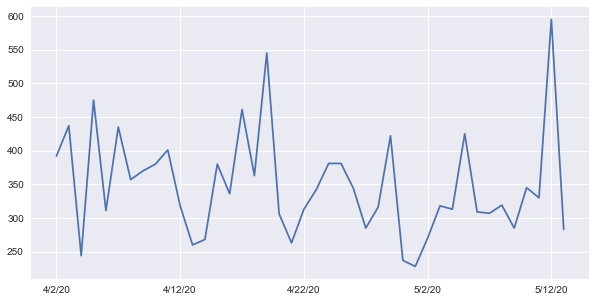

In [6]:
plt.figure(figsize=(10,5))
daily_growth_series.plot()

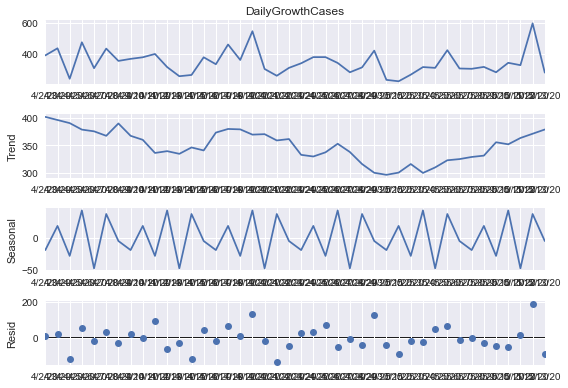

In [7]:
result = seasonal_decompose(daily_growth_series, model='additive', freq=7, extrapolate_trend='freq')
result.plot()
print() #avoid plot of doubel figure

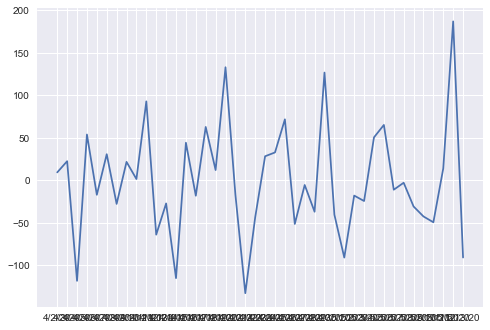

In [8]:
noise = result.resid
plt.plot(noise)

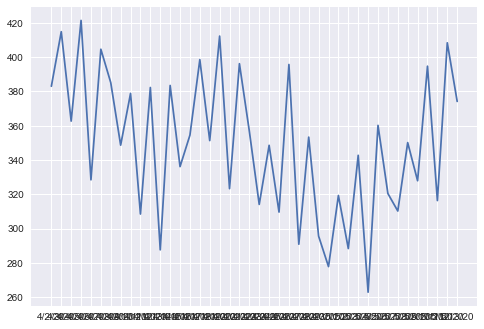

In [9]:
daily_no_noise = result.observed - noise
plt.plot(daily_no_noise)

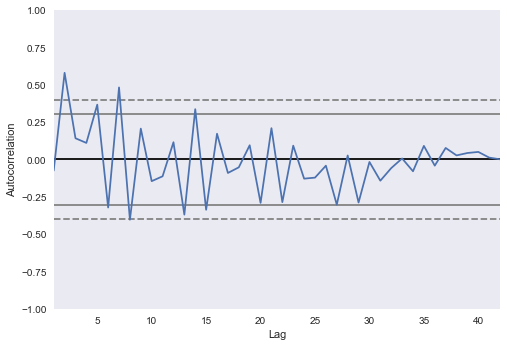

In [10]:
autocorrelation_plot(daily_no_noise)

predicted=318.448690, expected=310.196186
predicted=335.640210, expected=350.113703
predicted=300.823406, expected=327.864553
predicted=331.456251, expected=394.711492
predicted=322.599887, expected=316.293124
predicted=377.497028, expected=408.364553
predicted=329.650054, expected=374.150267
Test RMSE: 33.770


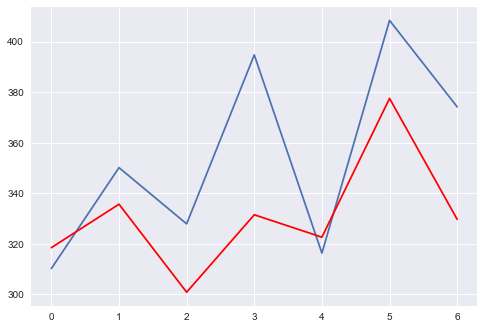

In [11]:
X = daily_no_noise.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse_res = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_res)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [12]:
daily_orginal = daily_growth_series[-7:].values

In [13]:
def rmse(actual,predicted):
    return(str(np.sqrt(mean_squared_error(actual, predicted))))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

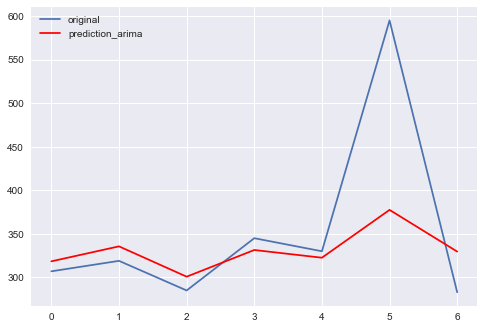

Test RMSE: 84.836
Test MAPE: 14.629


In [14]:
plt.plot(daily_orginal, label='original')
plt.plot(predictions, color='red', label='prediction_arima')

plt.legend()
plt.show()
rmse_arima = sqrt(mean_squared_error(daily_orginal, predictions))
mape_arima = mean_absolute_percentage_error(daily_orginal, predictions)

print('Test RMSE: %.3f' % rmse_arima)
print('Test MAPE: %.3f' % mape_arima)

In [15]:
predictions

[array([318.44869028]),
 array([335.64021041]),
 array([300.8234058]),
 array([331.45625063]),
 array([322.59988675]),
 array([377.49702845]),
 array([329.65005422])]

In [16]:
sum_pred = sum([i[0] for i in predictions])

In [17]:
daily_orginal.sum() - sum_pred

147.88447345804434

In [81]:
def predict_arima_week_ahead(train, param_order):

    predictions = list()
    conf_int = np.zeros((7,2))
    data = list(train)

    for t in range(7):
        model = ARIMA(data, order=param_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        data.append(yhat[0])
        conf_int[t][0] = output[2][0][0]
        conf_int[t][1] = output[2][0][1]

    return predictions, conf_int

In [82]:
prediction_week_ahead, conf_int = predict_arima_week_ahead(daily_no_noise.values, (2,1,0))

In [83]:
prediction_week_ahead, conf_int

([373.2663220062978,
  388.3687202042831,
  369.9935795856441,
  384.1320257561295,
  374.56654693539525,
  378.72089192555825,
  377.0842899684042],
 array([[313.0640568 , 433.46858721],
        [328.8888583 , 447.84858211],
        [311.21068154, 428.77647763],
        [326.02212222, 442.24192929],
        [317.10701727, 432.02607661],
        [321.89035627, 435.55142758],
        [320.86251611, 433.30606382]]))

In [64]:
df_5_20_20 = prepare_empty_frame(start_date='5/14/20', end_date='5/20/20', country='Poland')

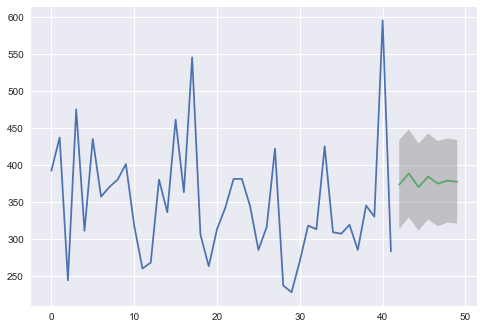

In [94]:
plt.plot(daily_growth_series.values)
# plt.plot(df_pred_melt)
plt.plot(np.linspace(42,49,7), prediction_week_ahead)
plt.fill_between(np.linspace(42,49,7),conf_int[:,0], conf_int[:,1], alpha=0.4, facecolor='grey')

In [95]:
index = 0
for date in df_5_20_20.columns[1:]:
    print(date, prediction_week_ahead[index])
    df_5_20_20[date] = prediction_week_ahead[index]
    index += 1

5/14/2020 373.2663220062978
5/15/2020 388.3687202042831
5/16/2020 369.9935795856441
5/17/2020 384.1320257561295
5/18/2020 374.56654693539525
5/19/2020 378.72089192555825
5/20/2020 377.0842899684042


In [96]:
poland_gt = prepare_europe_data(data=data_raw, start_date='5/13/20', end_date='5/20/20', country='Poland')

In [97]:
poland_gt

,Country/Region,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
34,Poland,17204,17615,18016,18257,18529,18885,19268,19739


Total confirmed cases for poland for 5/20/2020

In [98]:
predicted_total = poland_gt['5/13/20'].values[0] + df_5_20_20.values.reshape(-1)[1:].sum()
predicted_total

19850.132376381713

Ground truth

In [99]:
gt_total = poland_gt['5/20/20'].values[0]
gt_total

19739

In [100]:
gt_total - predicted_total

-111.13237638171267

Predicted for 5/20/20 - 19850.1

Official for 5/20/20 - 19739

Error - (-111) ConfirmedCases